In [9]:
import numpy as np  # to build the algorithm
import matplotlib.pyplot as plt  # to visualize
from sklearn.datasets import make_circles  # to generate a dataset

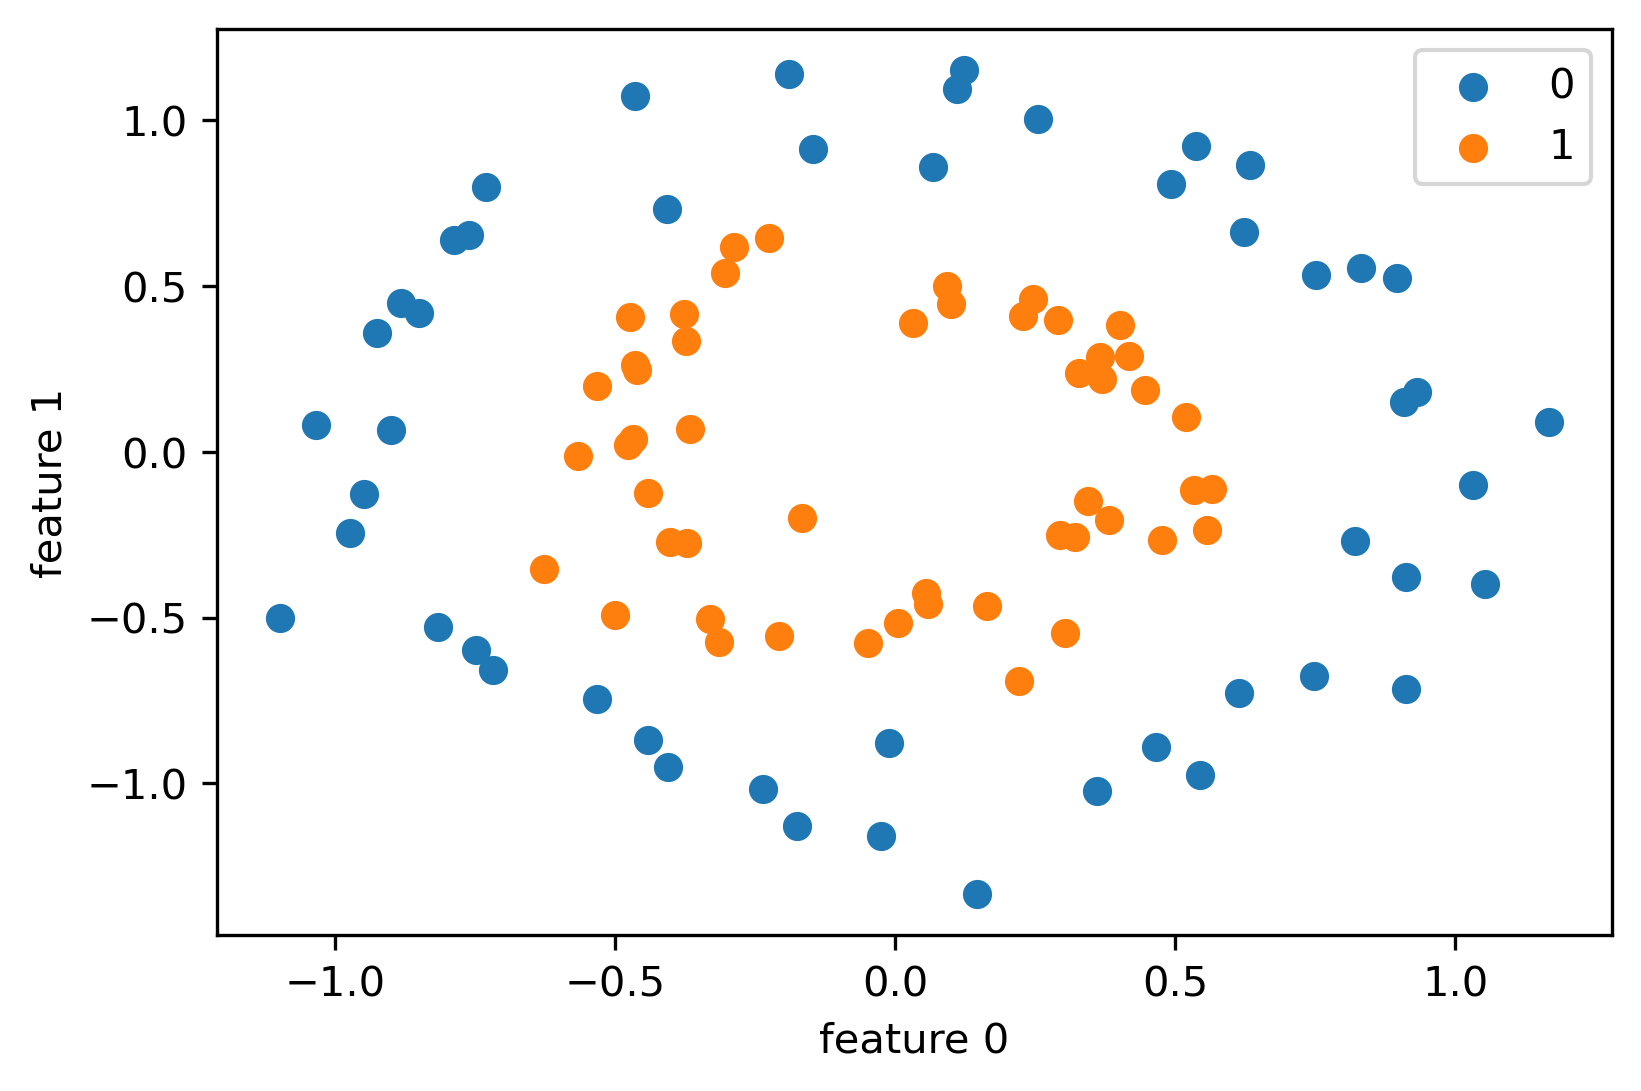

In [10]:
# Generate a dataset
X, y = make_circles(n_samples=100, noise=0.1, factor=0.5, random_state=0)
plt.figure(dpi=300)
plt.scatter(X[:, 0][y == 0], X[:, 1][y == 0], label=0)
plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1], label=1)
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.legend()

In [11]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=30)
clf.fit(X, y)

X_test, y_test = make_circles(n_samples=100, noise=0.1, factor=0.5, random_state=42)
y_pred = clf.predict(X_test)
acc = sum(y_pred == y_test)/len(y_test)
print('Accuracy: ', acc)

Accuracy:  0.96


In [12]:
clf.feature_importances_

array([0.48652932, 0.51347068])

In [13]:
# Challenge 1
def gini_calculator(y):
    '''
    Calculates the gini impurity of a set
    Arguments
        y: np.array() containing the labels
    Returns
        gini: 1 - p0^2 - p1^2
    '''
    probs = []
    for label in np.unique(y):
        prob = np.mean(y == label)
        probs.append(prob)
    gini = 1-np.sum(np.square(np.array(probs)))
    return gini

In [23]:
gini_calculator(y)

0.5

Text(0, 0.5, 'Gini impurity')

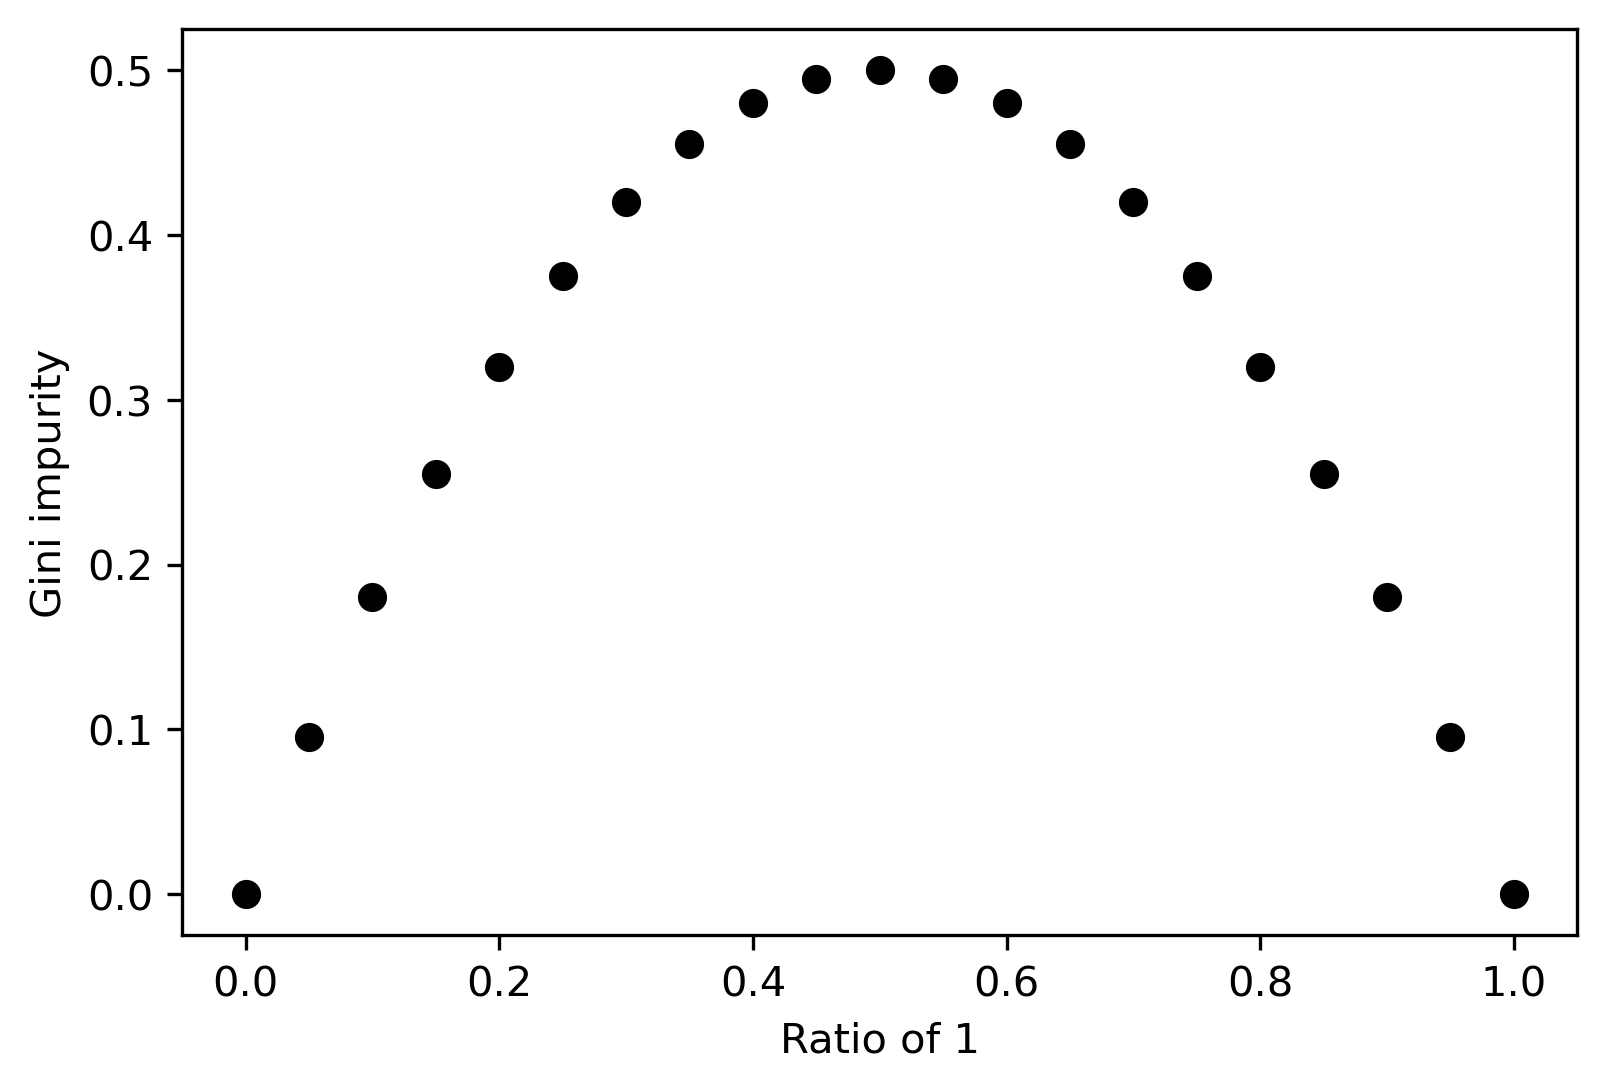

In [14]:
# Sanity check
num_datapoints = 20
plt.figure(dpi=300)
for i in range(num_datapoints+1):
    num_ones = i
    num_zeros = num_datapoints-i
    p1 = num_ones/num_datapoints
    combined_set = np.concatenate((np.ones(num_ones), np.zeros(num_zeros)))
    gini = gini_calculator(combined_set)
    plt.scatter(p1, gini, color='k')
plt.xlabel('Ratio of 1')
plt.ylabel('Gini impurity')

In [15]:
def gini_of_a_split(y1, y2):
    '''
    Weighted average gini of two sets
    Arguments
        y1: np.array() containing the labels of set 1
        y2: np.array() containing the labels of set 2
    Returns
        avg_gini: Weighted average gini of y1 and y2
    '''
    g1 = gini_calculator(y1)
    w1 = len(y1)/(len(y1)+len(y2))
    g2 = gini_calculator(y2)
    w2 = len(y2)/(len(y1)+len(y2))
    avg_gini = g1*w1 + g2*w2
    return avg_gini

In [19]:
# Challenge 2
from operator import itemgetter


def split_finder(X, y):
    '''
    Finds the best split that minimizes the average gini.
    Best split is defined by a feature index and its value.

    Arguments
        m = num_of_datapoints
        n = num_of_features
        X: np.array() shape (m, n)
        y: np.array() shape (m, 1)

    Returns
        best_split_feature: integer, best feature index
        best_split_value: float, best value

    '''
    #Finding the best split point in a decision tree 
    #involves evaluating the cost of each value in the training dataset for each input variable.
    # Calculate avg gini for all splits
    splits = []
    for j in range(X.shape[1]):  # j is the split feature
        for i in range(X.shape[0]):
            Xij = X[i, j]  # Xij is the split value
            y1 = y[X[:, j] < Xij]
            y2 = y[X[:, j] >= Xij]
            # Splitting using >= implies
            # Xij is the upper bound
            avg_gini = gini_of_a_split(y1, y2)
            splits.append([j, Xij, avg_gini])

    # Find the j and upper bound with min_avg_gini
    best_split = min(splits, key=itemgetter(2))
    best_split_feature, upper_bound, min_avg_gini = best_split

    # Find the lower bound
    j_values = X[:, best_split_feature]
    lower_bound = max(j_values[j_values < upper_bound])

    # Find the decision boundary
    best_split_value = np.mean((lower_bound, upper_bound))

    return best_split_feature, best_split_value

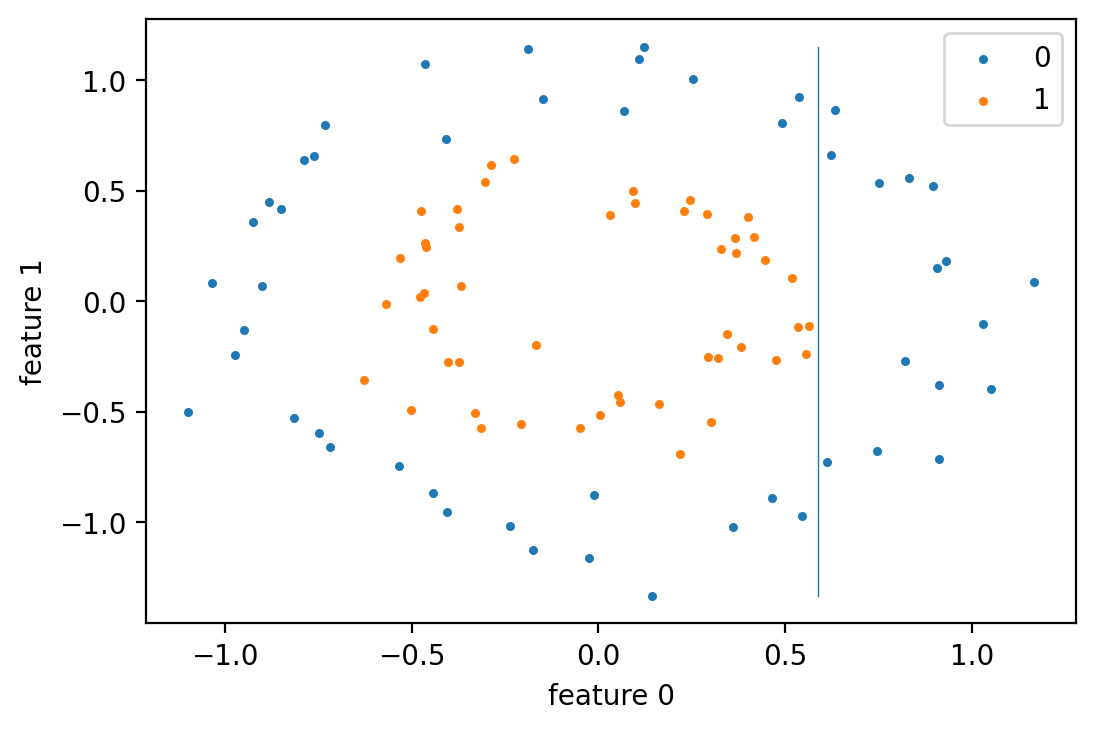

In [20]:
# Visualize the first split
best_split = split_finder(X, y)
plt.figure(dpi=200)
plt.scatter(X[:, 0][y == 0], X[:, 1][y == 0], label=0, s=5)
plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1], label=1, s=5)
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.legend()

split_feature = best_split[0]
split_value = best_split[1]
boundary_limits = [min(X[:, 1]), max(X[:, 1])]

if split_feature == 0:
    plt.plot([split_value, split_value], boundary_limits, lw=.5)
if split_feature == 1:
    plt.plot(boundary_limits, [split_value, split_value], lw=.5)

In [10]:
def splitter(X, y):
    '''
    This is one node split i.e. building block of a tree.

    Given X and y,
    - finds the split
    - splits the datasets into 2 subsets
    - returns the subsets and the split

    Arguments
        m = num_of_datapoints
        n = num_of_features
        X: np.array() shape (m, n)
        y: np.array() shape (m, 1)

    Returns
        subset1: list of np arrays, [X1, y1]
            X1: np.array() shape (m1, n)
            y1: np.array() shape (m1, 1)
        subset2: list of np arrays, [X2, y2]
            X2: np.array() shape (m2, n)
            y2: np.array() shape (m2, 1)
        where m = m1 + m2

        split: a tuple, (split_feature, split_value)
            split_feature: integer, best feature index
            split_value: float, best value
    '''
    split = split_finder(X, y)

    X1 = X[X[:, split[0]] < split[1]]
    y1 = y[X[:, split[0]] < split[1]]

    X2 = X[X[:, split[0]] > split[1]]
    y2 = y[X[:, split[0]] > split[1]]

    return (X1, y1), (X2, y2), split

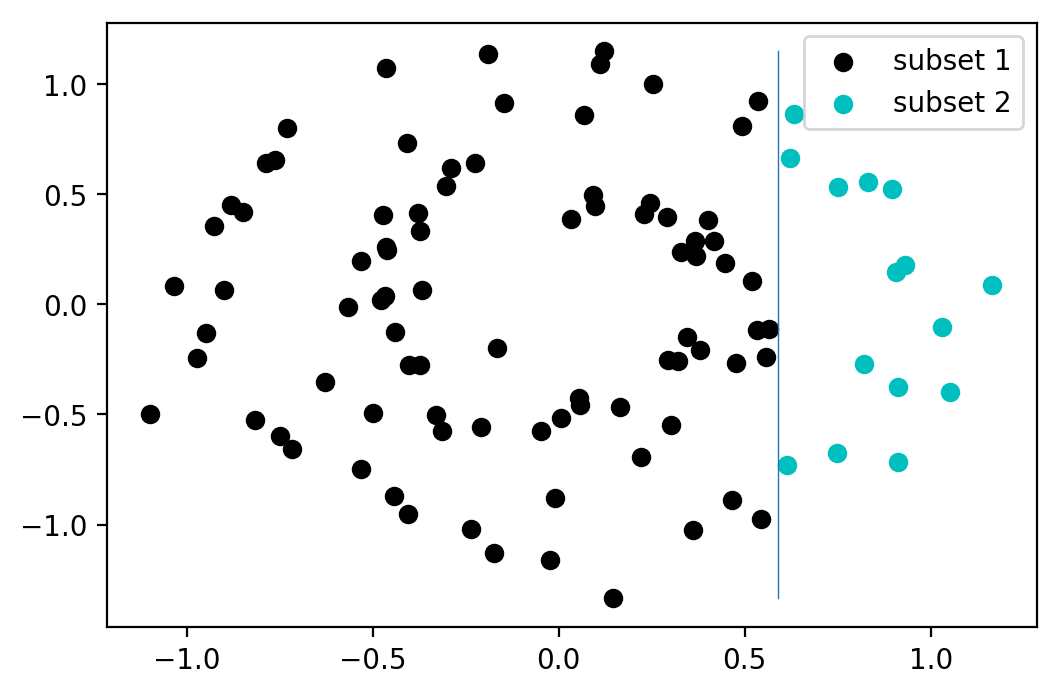

In [11]:
# Visualize the split and the subsets
subset1, subset2, split = splitter(X, y)
X1 = subset1[0]
X2 = subset2[0]

plt.figure(dpi=200)
plt.scatter(X1[:, 0], X1[:, 1], color='k', label='subset 1')
plt.scatter(X2[:, 0], X2[:, 1], color='c', label='subset 2')
plt.legend()

split_feature = split[0]
split_value = split[1]
boundary_limits = [min(X[:, 1]), max(X[:, 1])]

if split_feature == 0:
    plt.plot([split_value, split_value], boundary_limits, lw=.5)
if split_feature == 1:
    plt.plot(boundary_limits, [split_value, split_value], lw=.5)

In [12]:
# Challenge 3
def fit_tree(X, y):
    '''
    Repeat the splitter to fit a tree to X and y.
    return the tree i.e. the trained model

    Arguments
        m = num_of_datapoints
        n = num_of_features
        X: np.array() shape (m, n)
        y: np.array() shape (m, 1)

    Returns
        tree: a dictionary of nodes
            key: node name e.g. 'root', 'rootRL'
            value: node dictionary
                key:
                    'depth' int
                    'data' (subset_X, subset_y)
                    'class' majority class
                    'leaf' binary, leaf(1) or not(0)
                    'split_feature' 0 or 1
                    'split_value' float
    '''

    tree = {}

    depth = 0
    max_depth = 10

    # Init the root node
    node_name = 'root'
    tree[node_name] = {}
    tree[node_name]['depth'] = depth
    tree[node_name]['data'] = (X, y)
    tree[node_name]['class'] = np.bincount(y).argmax()
    tree[node_name]['leaf'] = 0

    while depth < max_depth:

        all_nodes = list(tree.keys())
        nodes_at_depth_i = []
        for node_name in all_nodes:
            if tree[node_name]['depth'] == depth:
                nodes_at_depth_i.append(node_name)

        for node_name in nodes_at_depth_i:

            if tree[node_name]['leaf'] == 1:continue
            X_parent, y_parent = tree[node_name]['data']
            Xy_child1, Xy_child2, split = splitter(X_parent, y_parent)

            tree[node_name]['split_feature'] = split[0]
            tree[node_name]['split_value'] = split[1]

            # Init child 1
            child1_name = node_name + 'L'
            tree[child1_name] = {}
            tree[child1_name]['depth'] = depth + 1
            tree[child1_name]['data'] = Xy_child1
            tree[child1_name]['class'] = np.bincount(Xy_child1[1]).argmax()
            # Termination condition
            if gini_calculator(Xy_child1[1]) != 0 and len(Xy_child1[1]) > 3:
                tree[child1_name]['leaf'] = 0
            else:
                tree[child1_name]['leaf'] = 1

            # Init child 2
            child2_name = node_name + 'R'
            tree[child2_name] = {}
            tree[child2_name]['depth'] = depth + 1
            tree[child2_name]['data'] = Xy_child2
            tree[child2_name]['class'] = np.bincount(Xy_child2[1]).argmax()
            # Termination condition
            if gini_calculator(Xy_child2[1]) != 0 and len(Xy_child2[1]) > 3:
                tree[child2_name]['leaf'] = 0
            else:
                tree[child2_name]['leaf'] = 1
                
        depth += 1
        
    return tree

In [13]:
tree = fit_tree(X, y)

In [14]:
# Challenge 4
def predict_tree(X, tree):
    '''
    Given X and the model (i.e. tree), return predictions

    Arguments
        X: np.array() shape (m, n)
        tree: a dictionary of nodes

    Returns
        y_pred: a list of predictions for each row of X,
                class labels 0 or 1.


    '''
    y_pred = []
    for i in range(X.shape[0]):
        node_name = 'root'
        data_point = X[i]
        x0 = data_point[0]
        x1 = data_point[1]

        while True:
            split_feature = tree[node_name]['split_feature']
            split_value = tree[node_name]['split_value']

            if split_feature == 0:
                feature_value = x0
            else:
                feature_value = x1

            if feature_value <= split_value:
                node_name = node_name + 'L'
                if tree[node_name]['leaf'] == 1:
                    y_pred.append(tree[node_name]['class'])
                    break
            else:
                node_name = node_name + 'R'
                if tree[node_name]['leaf'] == 1:
                    y_pred.append(tree[node_name]['class'])
                    break

    return y_pred

In [15]:
y_pred = predict_tree(X, tree)

In [16]:
def accuracy(y_pred, y):
    return sum(y_pred == y)/len(y)

In [17]:
accuracy(y_pred, y)

1.0

In [18]:
# Putting all together
# with Train/Test
X_train, y_train = make_circles(n_samples=100, noise=0.1, factor=0.5, random_state=0)
X_test, y_test = make_circles(n_samples=100, noise=0.1, factor=0.5, random_state=42)
tree = fit_tree(X_train, y_train)
y_pred_train = predict_tree(X_train, tree)
y_pred_test = predict_tree(X_test, tree)

print('Training acc:', accuracy(y_pred_train, y_train))
print('Testing acc:', accuracy(y_pred_test, y_test))

Training acc: 1.0
Testing acc: 0.94


In [19]:
# Challenge 5
def fit_forest(X, y):
    '''
    Fit 30 trees
    by randomly sampling from
    X and y
    return 30 trees
    '''
    num_trees = 30
    forest = []
    for i in range(num_trees):
        idx = np.random.choice(np.arange(len(y)), int(len(y)*0.8))
        X_sample = X[idx]
        y_sample = y[idx]
        tree = fit_tree(X_sample, y_sample)
        forest.append(tree)
    return forest

In [20]:
# Challenge 6
def predict_forest(X, forest):
    '''
    Predict the labels for X
    for all 30 trees
    calculate the average of 30 trees
    return avg. predictions
    '''
    y_preds = []
    for tree in forest:
        y_pred = predict_tree(X, tree)
        y_preds.append(y_pred)
    y_preds = np.array(y_preds)

    y_pred = np.mean(y_preds, axis=0)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    return y_pred

In [21]:
# Putting all together
# with Train/Test
X_train, y_train = make_circles(n_samples=100, noise=0.1, factor=0.5, random_state=0)
X_test, y_test = make_circles(n_samples=100, noise=0.1, factor=0.5, random_state=42)
forest = fit_forest(X_train, y_train)
y_pred_train = predict_forest(X_train, forest)
y_pred_test = predict_forest(X_test, forest)

print('Training acc:', accuracy(y_pred_train, y_train))
print('Testing acc:', accuracy(y_pred_test, y_test))

Training acc: 1.0
Testing acc: 0.96
